In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 50
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
dims = [3, 1, 1]
# dims = [196, 25, 2]

# gains = np.array([1, 2]) * 1e0
gains = np.array([1.5, 1.8]) * 1e1
np.random.seed(42)
use_loss = True

# input_spike_times = {
#     n: np.where(
#         np.random.poisson(lam=0.2, size=(timesteps - 1)).clip(0, 1).astype(int)
#     )[0].tolist()
#     for n in range(dims[0])
# }
input_spike_times = {
    k: np.random.choice(np.arange(timesteps-1), size=1) for k in range(dims[0])
}

# input_spike_times = {0 : [10], 1 : [20]}
# input_spike_times = {0: [0, 3, 5, 7, 10]}

print(input_spike_times)
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in input_spike_times.items() : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

{0: array([38]), 1: array([28]), 2: array([14])}


In [5]:
from eventprop.models import SNN

In [6]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop",
    "reset_to_zero" : True
}


In [7]:
eventprop_model = SNN(dims, **model_config)
layers = eventprop_model.layers
for layer, gain in zip(layers, gains) : 
    n2, n1 = layer.weight.shape
    nu = 1. / np.sqrt(n1)
    layer.weight.data = torch.from_numpy(np.random.normal(nu, nu, size=(n1, n2))).T.float() * gain
    # layer.weight.data = torch.zeros((n2, n1)).float()
    # layer.weight.data[0, :] = 1
    # layer.weight.data[-1, :] = -1


    # layer.weight.data = torch.ones((n2, n1)).float() * gain
eventprop_model.to(device)

SNN(
  (layers): RecordingSequential(
    (0): SpikingLinear_ev(3, 1)
    (1): SpikingLinear_ev(1, 1)
  )
)

In [8]:
packs = []
input = input_spikes.to(device)	
for layer in layers : 
    pack, _ = layer.manual_forward(input)
    packs.append(pack)
    input = pack[-1]

In [9]:
(inputs, Vs, V_spikes, Is, all_out_spikes) = list(zip(*packs))

In [10]:
all_spike_times = {}
for layer_id, (out_spikes, dim) in enumerate(zip(all_out_spikes, dims[1:])) : 
    all_spike_times[layer_id] = {}
    
    spike_times = torch.where(out_spikes[:, 0])
    spike_times = {
        n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dim)
    }
    spike_times
    first_spike_times = {
        n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dim)
    }
    first_spikes_only = torch.zeros_like(out_spikes)
    for n in range(dim) : 
        if first_spike_times[n] > 0 : 
            first_spikes_only[first_spike_times[n], 0, n] = 1
    all_spike_times[layer_id]["all"] = spike_times
    all_spike_times[layer_id]["first"] = first_spike_times

In [11]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [12]:
if True :
    labels = 0
    first_spike_errors = {
        n : 0 for n in range(dims[1])
    }
    t_l = first_spike_times[labels]
    sum0 = 0
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 : 
            sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
        
    label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
    first_spike_errors[labels] += label_error
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 and labels != n: 
            first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 
else : 
    label = 0
    first_spike_errors = {
        n : 100 if n == label else -100 for n in range(dims[-1])
    }

In [13]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [14]:
bw_packs = []
grads = first_spike_grads
for layer, pack in zip(layers[::-1], packs[::-1]) :         
    bw_pack = layer.manual_backward(grads, pack)
    grads = bw_pack[0]
    bw_packs.append(bw_pack)


{'jump': tensor([[1.4846]], device='cuda:0'), 'grad_output': tensor([[14.5824]], device='cuda:0'), 'grad_input': tensor([[0.]], device='cuda:0'), 'V_dot': tensor([[13.0963]], device='cuda:0'), 'lV[i+1]': tensor([[0.]], device='cuda:0'), 'lI[i+1]': tensor([[0.]], device='cuda:0'), 'lV[i]': tensor([[0.]], device='cuda:0'), 'lI[i]': tensor([[0.]], device='cuda:0')}
{'jump': tensor([[18.1486]], device='cuda:0'), 'grad_output': tensor([[20.4665]], device='cuda:0'), 'grad_input': tensor([[0., 0., 0.]], device='cuda:0'), 'V_dot': tensor([[1.7304]], device='cuda:0'), 'lV[i+1]': tensor([[0.]], device='cuda:0'), 'lI[i+1]': tensor([[0.]], device='cuda:0'), 'lV[i]': tensor([[0.]], device='cuda:0'), 'lI[i]': tensor([[0.]], device='cuda:0')}


In [15]:
grad_inputs, grad_weights, lVs, lIs = list(zip(*bw_packs[::-1]))

In [16]:
all_spike_times['stim'] = {}
all_spike_times['stim']['all'] = input_spike_times
all_spike_times = dict(sorted(all_spike_times.items(), key=lambda x : x != 'stim'))

In [17]:
sources = ['stim'] + list(range(len(layers)))

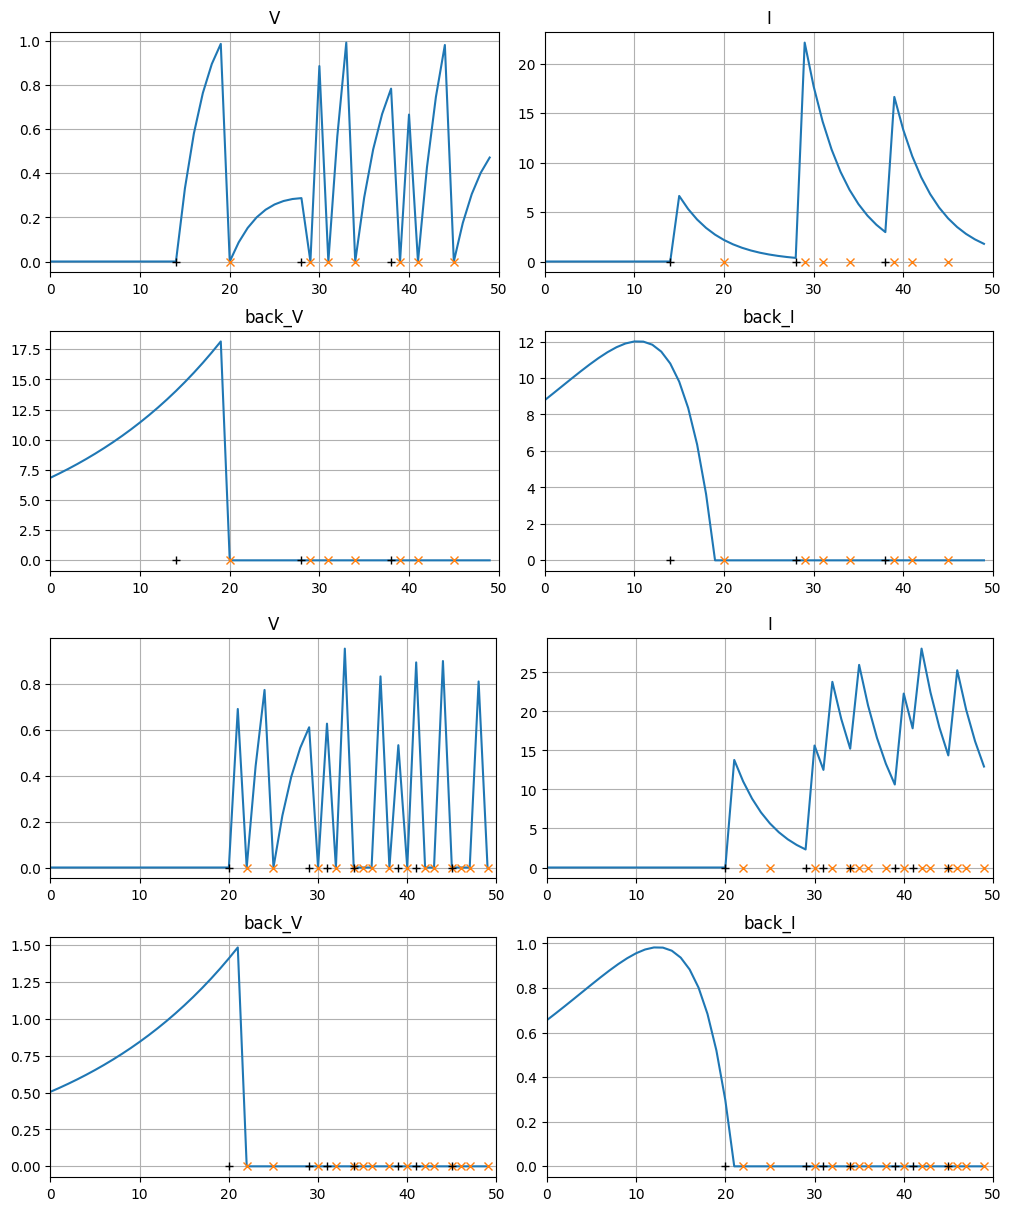

In [18]:
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for subfig, V, I, lV, lI, out_spike_source, in_spike_source, dim_out, dim_in in zip(
    subfigs,
    Vs,
    Is,
    lVs,
    lIs,
    sources[1:],
    sources[:-1],
    dims[1:],
    dims[:-1],
):
    axs = subfig.subplots(2, 2)
    for ax, data, title in zip(
        axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]
    ):
        # for n in range(dim_out) :
        ax.plot(data[:, 0].cpu().data.numpy())

        # print(in_spike_source, out_spike_source)
        out_spike_times = all_spike_times[out_spike_source]["all"]
        in_spike_times = all_spike_times[in_spike_source]["all"]

        ax.plot(
            np.concatenate(list(out_spike_times.values())),
            np.zeros_like(np.concatenate(list(out_spike_times.values()))),
            "x",
        )
        ax.plot(
            np.concatenate(list(in_spike_times.values())),
            np.zeros_like(np.concatenate(list(in_spike_times.values()))),
            "+",
            color='black'
        )

        ax.set_title(title)
        ax.grid(visible=True)
        ax.set_xlim(0, timesteps)

In [19]:
grad_weights

(tensor([[[ 0.0000,  0.0000, -0.0540]]], device='cuda:0',
        grad_fn=<SubBackward0>),
 tensor([[[-0.0015]]], device='cuda:0', grad_fn=<SubBackward0>))

In [20]:
lIs[0].squeeze()

tensor([ 8.7825,  9.1759,  9.5729,  9.9691, 10.3594, 10.7366, 11.0916, 11.4128,
        11.6853, 11.8901, 12.0031, 11.9938, 11.8238, 11.4445, 10.7948,  9.7980,
         8.3574,  6.3520,  3.6297,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
lVs[1].squeeze().cpu().data.numpy()[::-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.4846362 , 1.4104043 ,
       1.339884  , 1.2728899 , 1.2092453 , 1.1487831 , 1.0913439 ,
       1.0367767 , 0.9849378 , 0.9356909 , 0.8889063 , 0.84446096,
       0.8022379 , 0.762126  , 0.7240197 , 0.6878187 , 0.6534278 ,
       0.6207564 , 0.5897186 , 0.56023264, 0.532221  , 0.50561   ],
      dtype=float32)

In [22]:
lIs[1].squeeze().cpu().data.numpy()[::-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.29692724,
       0.5196227 , 0.68367493, 0.80151796, 0.88306344, 0.9362074 ,
       0.96723473, 0.9811431 , 0.98190206, 0.9726599 , 0.9559092 ,
       0.93361956, 0.90734327, 0.87829983, 0.8474438 , 0.81551886,
       0.78310066, 0.7506318 , 0.7184492 , 0.6868059 , 0.6558889 ],
      dtype=float32)

In [23]:
grad_weights[1].item()#, grad_weights[0].cpu().data.numpy()


-0.0014846362173557281

In [24]:
grad_weights

(tensor([[[ 0.0000,  0.0000, -0.0540]]], device='cuda:0',
        grad_fn=<SubBackward0>),
 tensor([[[-0.0015]]], device='cuda:0', grad_fn=<SubBackward0>))

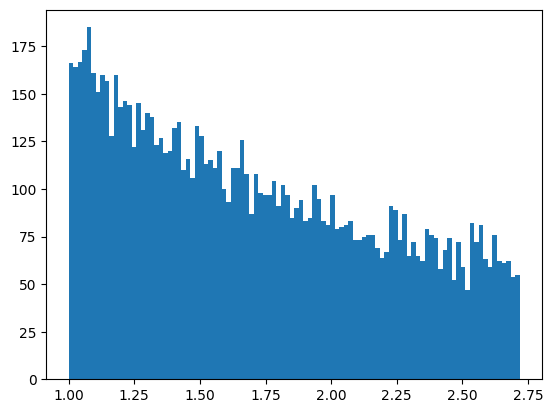

In [25]:
plt.hist([np.exp(np.random.rand()) for _ in range(10000)], bins=100);

In [26]:
np.random.uniform(np.log(0.1), np.log(1e-3))

-2.4504551757146054

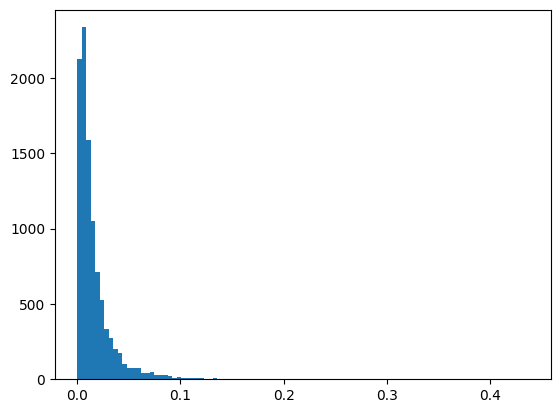

In [27]:
plt.hist(np.exp(np.random.normal(np.log(1e-2), 1, size=10000)), bins=100);
# plt.loglog()

In [28]:
np.log(1e-2)

-4.605170185988091

In [29]:
unique_times = np.unique(np.concatenate(list(all_spike_times[0]['all'].values())), return_counts=True)[1]
unique_times.sort()
unique_times

array([1, 1, 1, 1, 1, 1, 1])

In [30]:
offline_times = all_spike_times[0]['all']